# Evaluación y analisis de los resultados de la segmentación de lesiones de esclerosis múltiple en imágenes de resonancia magnética

Este cuaderno de Jupyter es un analisis de los resultados de hacer la predicción de la segmentación de lesiones de esclerosis múltiple en imágenes de resonancia magnética utilizando la red neuronal nnUNet.

In [1]:
import os

In [2]:
os.chdir('..')
os.getcwd()


'c:\\Users\\mrtwe\\TFM\\nnUNet-em'

In [3]:
from scripts.A_config import NNUNetMSSEG2Config, DatasetType
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(3)
np.random.seed(3)

In [4]:
TRAINER='nnUNetTrainerCustomOversamplingEarlyStopping'
DATASET=NNUNetMSSEG2Config().DATASET_NAME
TEST_FOLDER = str(NNUNetMSSEG2Config().TEST_RESULTS_PATH / DATASET / TRAINER) + '__' + NNUNetMSSEG2Config().PLAN + '__' + NNUNetMSSEG2Config().CONFIGURATION

In [5]:
TEST_FOLDER

'C:\\Users\\mrtwe\\TFM\\nnUNet-em\\nnUNet_test_results\\Dataset101_NewLesionsChallenge\\nnUNetTrainerCustomOversamplingEarlyStopping__nnUNetPlans__3d_fullres'

In [6]:
DATASET = DatasetType.TEST_SPLIT


In [7]:
test_images = [file for file in os.listdir(TEST_FOLDER) if file.endswith(NNUNetMSSEG2Config().TERMINATION)]
test_ids = sorted({file_name.split(".")[0] for file_name in test_images})

In [8]:
print(test_images)

['013.nii.gz', '015.nii.gz', '016.nii.gz', '018.nii.gz', '019.nii.gz', '020.nii.gz', '021.nii.gz', '024.nii.gz', '026.nii.gz', '027.nii.gz', '029.nii.gz', '030.nii.gz', '032.nii.gz', '035.nii.gz', '037.nii.gz', '039.nii.gz', '043.nii.gz', '047.nii.gz', '048.nii.gz', '049.nii.gz', '051.nii.gz', '052.nii.gz', '057.nii.gz', '061.nii.gz', '068.nii.gz', '069.nii.gz', '070.nii.gz', '074.nii.gz', '077.nii.gz', '083.nii.gz', '084.nii.gz', '088.nii.gz', '089.nii.gz', '090.nii.gz', '091.nii.gz', '094.nii.gz', '095.nii.gz', '096.nii.gz', '099.nii.gz', '100.nii.gz', 'patient1.nii.gz', 'patient10.nii.gz', 'patient11.nii.gz', 'patient12.nii.gz', 'patient13.nii.gz', 'patient14.nii.gz', 'patient15.nii.gz', 'patient16.nii.gz', 'patient17.nii.gz', 'patient18.nii.gz', 'patient19.nii.gz', 'patient2.nii.gz', 'patient20.nii.gz', 'patient3.nii.gz', 'patient4.nii.gz', 'patient5.nii.gz', 'patient6.nii.gz', 'patient7.nii.gz', 'patient8.nii.gz', 'patient9.nii.gz']


In [9]:
print(test_ids)

['013', '015', '016', '018', '019', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '049', '051', '052', '057', '061', '068', '069', '070', '074', '077', '083', '084', '088', '089', '090', '091', '094', '095', '096', '099', '100', 'patient1', 'patient10', 'patient11', 'patient12', 'patient13', 'patient14', 'patient15', 'patient16', 'patient17', 'patient18', 'patient19', 'patient2', 'patient20', 'patient3', 'patient4', 'patient5', 'patient6', 'patient7', 'patient8', 'patient9']


In [10]:
def get_image_path(case_id, dataset=DATASET, basal_im=False, follow_up_im=False, labels=False, preds=False):
    """
    Obtiene el path de la imagen dado el ID del caso y el tipo de dataset.

    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :param basal_im: Booleano para incluir imagen basal
    :param follow_up_im: Booleano para incluir imagen de seguimiento
    :param labels: Booleano para incluir etiquetas
    :param preds: Booleano para incluir predicciones
    :return: Path de la imagen
    """
    config = NNUNetMSSEG2Config()
    termination = config.TERMINATION
    images_dir = config.train_images_dir if dataset == DatasetType.TRAIN_SPLIT else config.test_images_dir
    labels_dir = config.train_labels_dir if dataset == DatasetType.TRAIN_SPLIT else config.test_labels_dir
    predictions_dir = TEST_FOLDER

    paths = []
    if basal_im:
        paths.append(os.path.join(images_dir, f"{case_id}_0000{termination}"))
    if follow_up_im:
        paths.append(os.path.join(images_dir, f"{case_id}_0001{termination}"))
    if labels and labels_dir:
        paths.append(os.path.join(labels_dir, f"{case_id}_01{termination}"))
    if preds and predictions_dir:
        paths.append(os.path.join(predictions_dir, f"{case_id}{termination}"))

    if not paths:
        raise FileNotFoundError(f"No se encontró la imagen para el caso ID: {case_id}")

    return tuple(paths)

# Ejemplo de uso
# case_id = random.choice(test_ids)
case_num_idx = random.randint(0, len(test_ids))
case_id = test_ids.pop(case_num_idx)
label_path,image_path = get_image_path(case_id, DATASET, labels=True, preds=True)
print(f"ID del caso: {case_id}")
print(f"Path de la imagen: {image_path}")
print(f"Path de las etiquetas: {label_path}")

ID del caso: 039
Path de la imagen: C:\Users\mrtwe\TFM\nnUNet-em\nnUNet_test_results\Dataset101_NewLesionsChallenge\nnUNetTrainerCustomOversamplingEarlyStopping__nnUNetPlans__3d_fullres\039.nii.gz
Path de las etiquetas: C:\Users\mrtwe\TFM\nnUNet-em\nnUNet_raw_data\Dataset101_NewLesionsChallenge\labelsTs\039_01.nii.gz


In [11]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

resultados = compute_metrics(
    reference_file=label_path,
    prediction_file=image_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1,2]
)

In [12]:
def read_image(case_id, dataset=DATASET):
    """
    Lee la imagen de un caso dado el ID del caso y el tipo de dataset.

    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :return: Imagen
    """
    basal_image_path, follow_up_image_path = get_image_path(case_id, DATASET, basal_im=True, follow_up_im=True)
    basal_image = nib.load(basal_image_path).get_fdata()
    follow_up_image = nib.load(follow_up_image_path).get_fdata()
    return basal_image, follow_up_image

def read_labels_and_predictions(case_id, dataset=DATASET):
    """
    Lee las etiquetas y las predicciones de un caso dado el ID del caso y el tipo de dataset.
    
    :param case_id: ID del caso
    :param dataset: Tipo de dataset (por defecto es DATASET)
    :return: Etiquetas y predicciones
    """
    label_path, prediction_path = get_image_path(case_id, dataset, labels=True, preds=True)
    labels = nib.load(label_path).get_fdata()
    predictions = nib.load(prediction_path).get_fdata()
    return labels, predictions

In [13]:
basal_image, follow_up_image = read_image(case_id, dataset=DATASET)

labels, predictions = read_labels_and_predictions(case_id, dataset=DATASET)

In [14]:
basal_image.shape, follow_up_image.shape, labels.shape, predictions.shape

((182, 218, 182), (182, 218, 182), (182, 218, 182), (182, 218, 182))

In [15]:
sample_b_image_path, sample_fu_image_path = get_image_path(case_id=case_id, dataset=DATASET,
                                                            basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

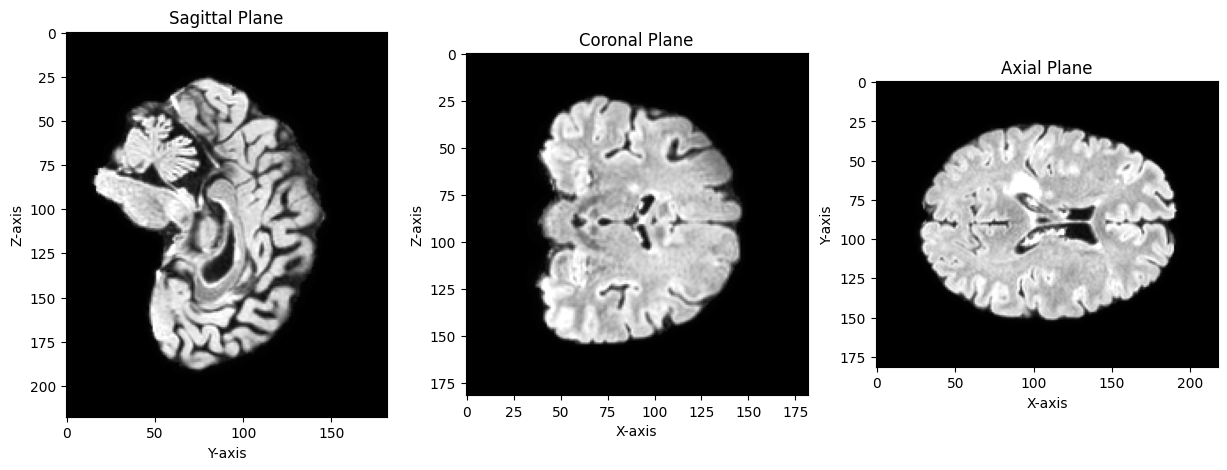

In [16]:
def plot_three_planes(image):
    """
    Plots the three planes (sagittal, coronal, axial) of the given image.

    :param image: Nibabel image object
    """
    data = image.get_fdata()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Sagittal plane (x-axis)
    axes[0].imshow(data[data.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Sagittal Plane')
    axes[0].set_xlabel('Y-axis')
    axes[0].set_ylabel('Z-axis')

    # Coronal plane (y-axis)
    axes[1].imshow(data[:, data.shape[1] // 2, :], cmap='gray')
    axes[1].set_title('Coronal Plane')
    axes[1].set_xlabel('X-axis')
    axes[1].set_ylabel('Z-axis')

    # Axial plane (z-axis)
    axes[2].imshow(data[:, :, data.shape[2] // 2], cmap='gray')
    axes[2].set_title('Axial Plane')
    axes[2].set_xlabel('X-axis')
    axes[2].set_ylabel('Y-axis')

    plt.show()

plot_three_planes(raw_sample_b_image)

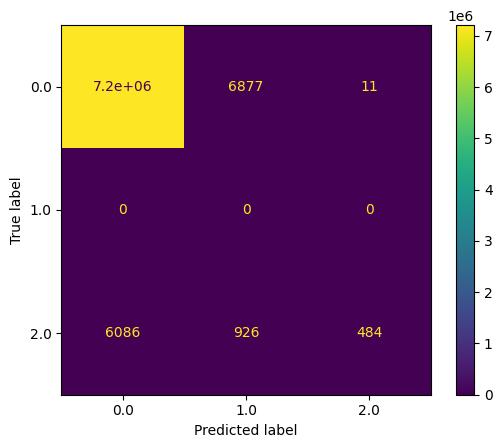

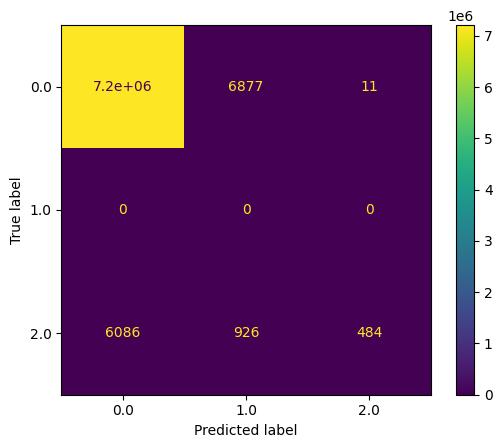

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay 

ConfusionMatrixDisplay.from_predictions(y_true=labels.flatten(), y_pred=predictions.flatten()).plot()

In [18]:
resultados['metrics']

{1: {'Dice': 0.0,
  'IoU': 0.0,
  'FP': 7803,
  'TP': 0,
  'FN': 0,
  'TN': 7213229,
  'n_pred': 7803,
  'n_ref': 0},
 2: {'Dice': 0.12113627831310224,
  'IoU': 0.06447315838550687,
  'FP': 11,
  'TP': 484,
  'FN': 7012,
  'TN': 7213525,
  'n_pred': 495,
  'n_ref': 7496}}

In [19]:

def get_lesion_locations(labels, lesion_id=None):
    """
    Devuelve la localización de las lesiones en la matriz de etiquetas.

    :param labels: Matriz de etiquetas
    :param lesion_id: ID de la lesión a buscar
    :return: Lista de tuplas con las coordenadas de las lesiones
    """
    lesion_locations = []
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                if labels[i, j, k] == lesion_id:
                    lesion_locations.append((i, j, k))
    return lesion_locations

basal_lesion_locations = get_lesion_locations(labels, lesion_id=1)
basal_lesion_prediction_locations = get_lesion_locations(predictions, lesion_id=1)


if basal_lesion_locations:
    sample_basal_lesion_central_voxel = random.choice(basal_lesion_locations)

    sample_basal_lesion_centroid = tuple(
        np.mean(basal_lesion_locations, axis=0).astype(int)
    )

    print("Voxel central de una lesión:", sample_basal_lesion_central_voxel)
    print("Centroide aproximado de las lesiones:", sample_basal_lesion_centroid)
else:
    print("No se encontraron lesiones con el ID especificado.")
    
if basal_lesion_prediction_locations:
    sample_basal_lesion_prediction_central_voxel = random.choice(basal_lesion_prediction_locations)


    sample_basal_lesion_prediction_centroid = tuple(
        np.mean(basal_lesion_prediction_locations, axis=0).astype(int)
    )

   
    print("Voxel central de una lesión predicha:", sample_basal_lesion_prediction_central_voxel)
    print("Centroide aproximado de las lesiones predichas:", sample_basal_lesion_prediction_centroid)
else:
    print("No se encontraron lesiones con el ID especificado.")


No se encontraron lesiones con el ID especificado.
Voxel central de una lesión predicha: (75, 90, 97)
Centroide aproximado de las lesiones predichas: (78, 97, 95)


In [20]:
def plot_basal_lesion_planes(basal_image, follow_up_image, labels, lesion_voxel, zoom_size=20, apply_zoom=True):
    """
    Plots the three planes (sagittal, coronal, axial) of the given images and lesion with optional zoom.

    :param basal_image: Numpy array of the basal image
    :param follow_up_image: Numpy array of the follow-up image
    :param labels: Numpy array of the labels (binary: 0 or 1)
    :param lesion_voxel: Tuple with the coordinates of the lesion voxel
    :param zoom_size: Size of the zoomed area around the lesion voxel
    :param apply_zoom: Boolean to apply zoom or not
    :return: Matplotlib figure object
    """
    # Asegúrate de que la máscara sea binaria
    labels = np.where(labels > 0, 1, 0)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    if apply_zoom:
        
        x_min, x_max = max(0, lesion_voxel[0] - zoom_size), min(basal_image.shape[0], lesion_voxel[0] + zoom_size)
        y_min, y_max = max(0, lesion_voxel[1] - zoom_size), min(basal_image.shape[1], lesion_voxel[1] + zoom_size)
        z_min, z_max = max(0, lesion_voxel[2] - zoom_size), min(basal_image.shape[2], lesion_voxel[2] + zoom_size)
    else:
        
        x_min, x_max = 0, basal_image.shape[0]
        y_min, y_max = 0, basal_image.shape[1]
        z_min, z_max = 0, basal_image.shape[2]

    
    axes[0, 0].imshow(basal_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 0].set_title('Basal Image - Sagittal Plane')
    axes[0, 0].set_xlabel('Y-axis')
    axes[0, 0].set_ylabel('Z-axis')

    axes[0, 1].imshow(follow_up_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 1].set_title('Follow-up Image - Sagittal Plane')
    axes[0, 1].set_xlabel('Y-axis')
    axes[0, 1].set_ylabel('Z-axis')

    axes[0, 2].imshow(basal_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 2].imshow(labels[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='autumn', alpha=0.3)  
    axes[0, 2].set_title('Basal Image with Lesion - Sagittal Plane')
    axes[0, 2].set_xlabel('Y-axis')
    axes[0, 2].set_ylabel('Z-axis')

    axes[1, 0].imshow(basal_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 0].set_title('Basal Image - Coronal Plane')
    axes[1, 0].set_xlabel('X-axis')
    axes[1, 0].set_ylabel('Z-axis')

    axes[1, 1].imshow(follow_up_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 1].set_title('Follow-up Image - Coronal Plane')
    axes[1, 1].set_xlabel('X-axis')
    axes[1, 1].set_ylabel('Z-axis')

    axes[1, 2].imshow(basal_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 2].imshow(labels[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='autumn', alpha=0.3)  
    axes[1, 2].set_title('Basal Image with Lesion - Coronal Plane')
    axes[1, 2].set_xlabel('X-axis')
    axes[1, 2].set_ylabel('Z-axis')

    axes[2, 0].imshow(basal_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 0].set_title('Basal Image - Axial Plane')
    axes[2, 0].set_xlabel('X-axis')
    axes[2, 0].set_ylabel('Y-axis')

    axes[2, 1].imshow(follow_up_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 1].set_title('Follow-up Image - Axial Plane')
    axes[2, 1].set_xlabel('X-axis')
    axes[2, 1].set_ylabel('Y-axis')

    axes[2, 2].imshow(basal_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 2].imshow(labels[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='autumn', alpha=0.3)  
    axes[2, 2].set_title('Basal Image with Lesion - Axial Plane')
    axes[2, 2].set_xlabel('X-axis')
    axes[2, 2].set_ylabel('Y-axis')

    plt.tight_layout()
    
    
    return fig


In [21]:
plot_basal_lesion_planes(basal_image, follow_up_image, labels, sample_basal_lesion_central_voxel, zoom_size=20, apply_zoom=False)

NameError: name 'sample_basal_lesion_central_voxel' is not defined

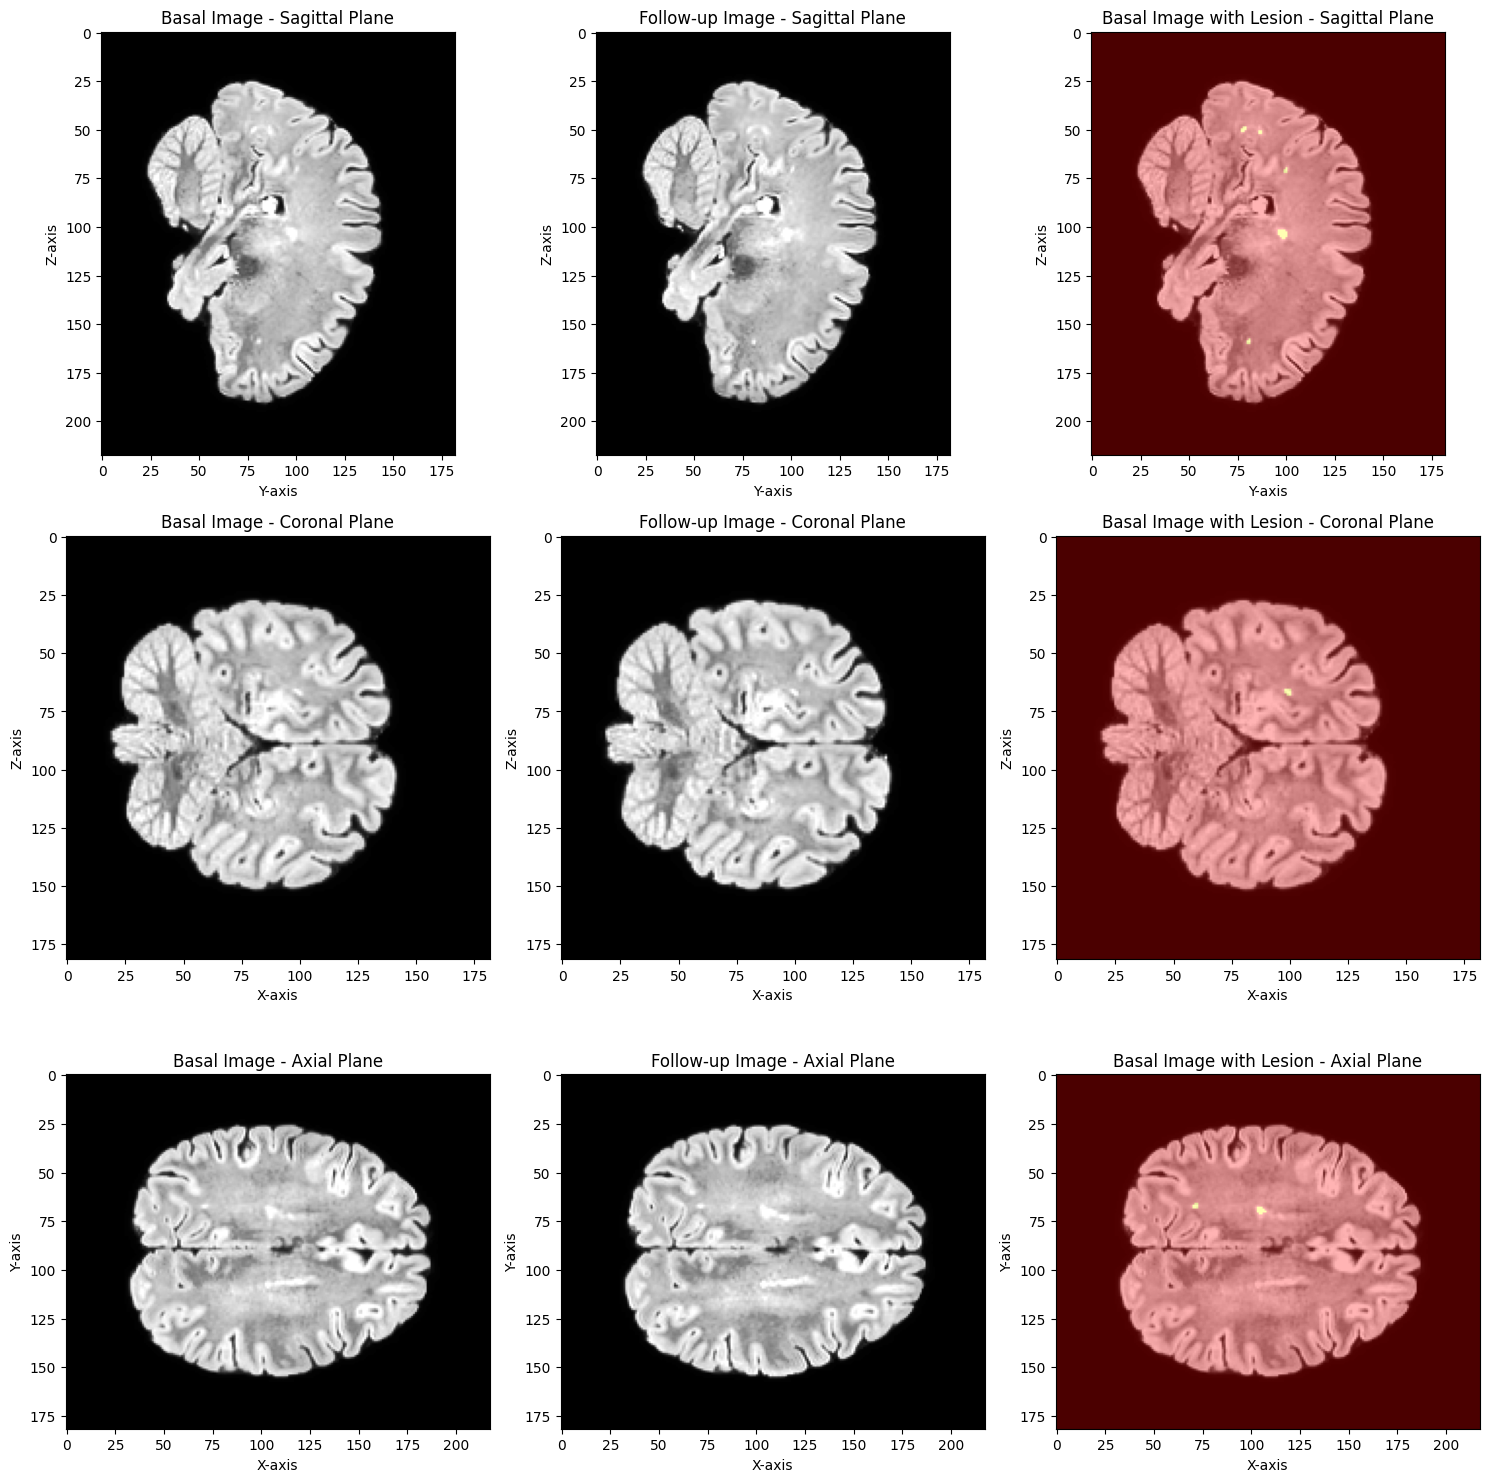

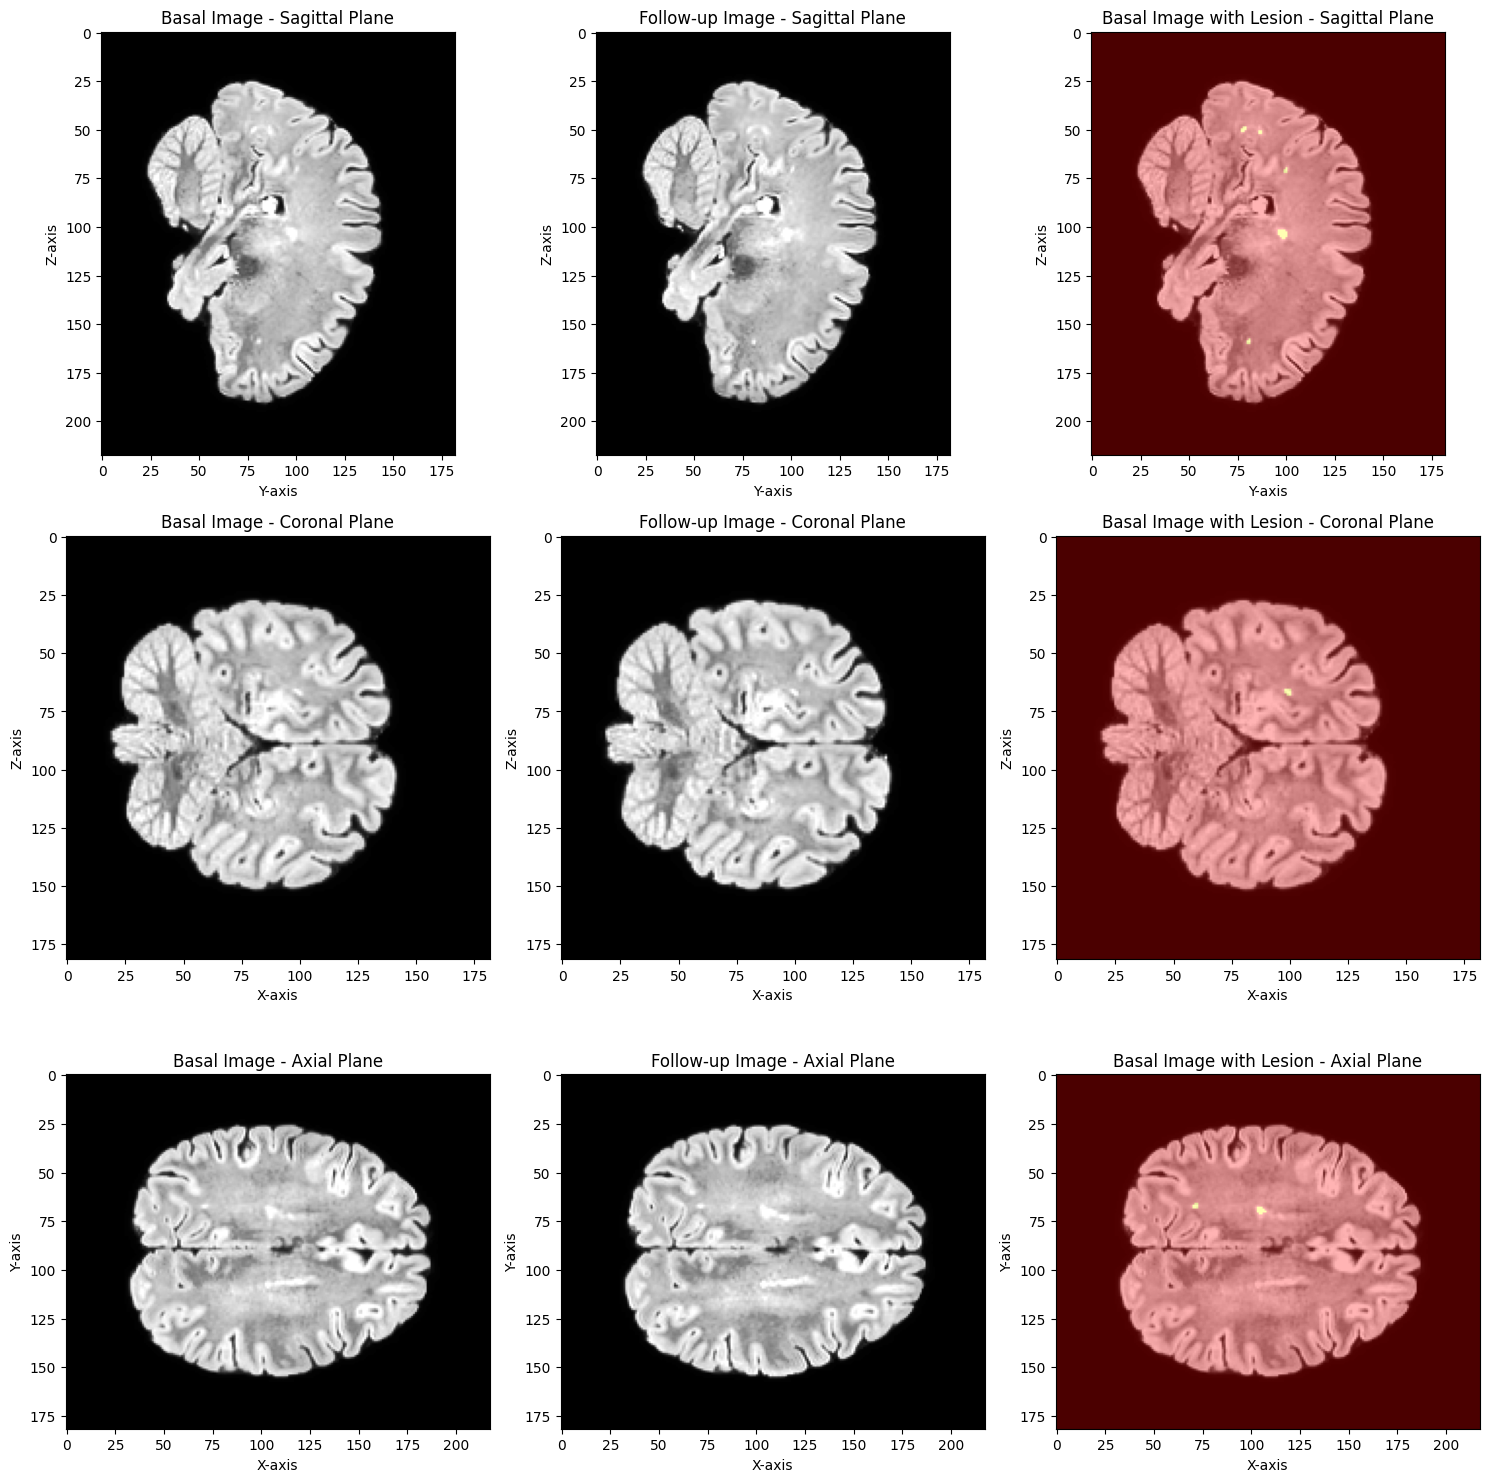

In [ ]:
plot_basal_lesion_planes(basal_image, follow_up_image, predictions, sample_basal_lesion_prediction_central_voxel, zoom_size=20, apply_zoom=False)

In [ ]:

new_lesion_locations = get_lesion_locations(labels, lesion_id=2)
new_lesion_prediction_locations = get_lesion_locations(predictions, lesion_id=2)



if new_lesion_locations:
    
    sample_new_lesion_central_voxel = random.choice(new_lesion_locations)

    
    sample_new_lesion_centroid = tuple(
        np.mean(new_lesion_locations, axis=0).astype(int)
    )

    
    print("Voxel central de una lesión:", sample_new_lesion_central_voxel)
    print("Centroide aproximado de las lesiones:", sample_new_lesion_centroid)
else:
    print("No se encontraron lesiones con el ID especificado.")
    
if new_lesion_prediction_locations:
    
    sample_new_lesion_prediction_central_voxel = random.choice(new_lesion_prediction_locations)

    
    sample_new_lesion_prediction_centroid = tuple(
        np.mean(new_lesion_prediction_locations, axis=0).astype(int)
    )

    
    print("Voxel central de una lesión predicha:", sample_new_lesion_prediction_central_voxel)
    print("Centroide aproximado de las lesiones predichas:", sample_new_lesion_prediction_centroid)
else:
    print("No se encontraron lesiones con el ID especificado.")


No se encontraron lesiones con el ID especificado.
Voxel central de una lesión predicha: (106, 113, 73)
Centroide aproximado de las lesiones predichas: (106, 113, 73)


In [29]:
def plot_follow_up_lesion_planes(basal_image, follow_up_image, labels, lesion_voxel, zoom_size=20, apply_zoom=True):
    """
    Plots the three planes (sagittal, coronal, axial) of the given images and lesion with optional zoom.

    :param basal_image: Numpy array of the basal image
    :param follow_up_image: Numpy array of the follow-up image
    :param labels: Numpy array of the labels (binary: 0 or 1)
    :param lesion_voxel: Tuple with the coordinates of the lesion voxel
    :param zoom_size: Size of the zoomed area around the lesion voxel
    :param apply_zoom: Boolean to apply zoom or not
    :return: Matplotlib figure object
    """
    
    labels = np.where(labels > 0, 1, 0)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    if apply_zoom:
        
        x_min, x_max = max(0, lesion_voxel[0] - zoom_size), min(basal_image.shape[0], lesion_voxel[0] + zoom_size)
        y_min, y_max = max(0, lesion_voxel[1] - zoom_size), min(basal_image.shape[1], lesion_voxel[1] + zoom_size)
        z_min, z_max = max(0, lesion_voxel[2] - zoom_size), min(basal_image.shape[2], lesion_voxel[2] + zoom_size)
    else:
        
        x_min, x_max = 0, basal_image.shape[0]
        y_min, y_max = 0, basal_image.shape[1]
        z_min, z_max = 0, basal_image.shape[2]

    
    axes[0, 0].imshow(basal_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 0].set_title('Basal Image - Sagittal Plane')
    axes[0, 0].set_xlabel('Y-axis')
    axes[0, 0].set_ylabel('Z-axis')

    axes[0, 1].imshow(follow_up_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 1].set_title('Follow-up Image - Sagittal Plane')
    axes[0, 1].set_xlabel('Y-axis')
    axes[0, 1].set_ylabel('Z-axis')

    axes[0, 2].imshow(follow_up_image[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='gray')
    axes[0, 2].imshow(labels[lesion_voxel[0], y_min:y_max, z_min:z_max], cmap='autumn', alpha=0.3)  
    axes[0, 2].set_title('Follow-up Image with Lesion - Sagittal Plane')
    axes[0, 2].set_xlabel('Y-axis')
    axes[0, 2].set_ylabel('Z-axis')

    
    axes[1, 0].imshow(basal_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 0].set_title('Basal Image - Coronal Plane')
    axes[1, 0].set_xlabel('X-axis')
    axes[1, 0].set_ylabel('Z-axis')

    axes[1, 1].imshow(follow_up_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 1].set_title('Follow-up Image - Coronal Plane')
    axes[1, 1].set_xlabel('X-axis')
    axes[1, 1].set_ylabel('Z-axis')

    axes[1, 2].imshow(follow_up_image[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='gray')
    axes[1, 2].imshow(labels[x_min:x_max, lesion_voxel[1], z_min:z_max], cmap='autumn', alpha=0.3)  
    axes[1, 2].set_title('Follow-up Image with Lesion - Coronal Plane')
    axes[1, 2].set_xlabel('X-axis')
    axes[1, 2].set_ylabel('Z-axis')

    
    axes[2, 0].imshow(basal_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 0].set_title('Basal Image - Axial Plane')
    axes[2, 0].set_xlabel('X-axis')
    axes[2, 0].set_ylabel('Y-axis')

    axes[2, 1].imshow(follow_up_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 1].set_title('Follow-up Image - Axial Plane')
    axes[2, 1].set_xlabel('X-axis')
    axes[2, 1].set_ylabel('Y-axis')

    axes[2, 2].imshow(follow_up_image[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='gray')
    axes[2, 2].imshow(labels[x_min:x_max, y_min:y_max, lesion_voxel[2]], cmap='autumn', alpha=0.3)  
    axes[2, 2].set_title('Follow-up Image with Lesion - Axial Plane')
    axes[2, 2].set_xlabel('X-axis')
    axes[2, 2].set_ylabel('Y-axis')

    plt.tight_layout()
    
    
    return fig

In [ ]:
if new_lesion_locations:
    plot_follow_up_lesion_planes(basal_image, follow_up_image, labels, sample_new_lesion_central_voxel, zoom_size=20, apply_zoom=False)

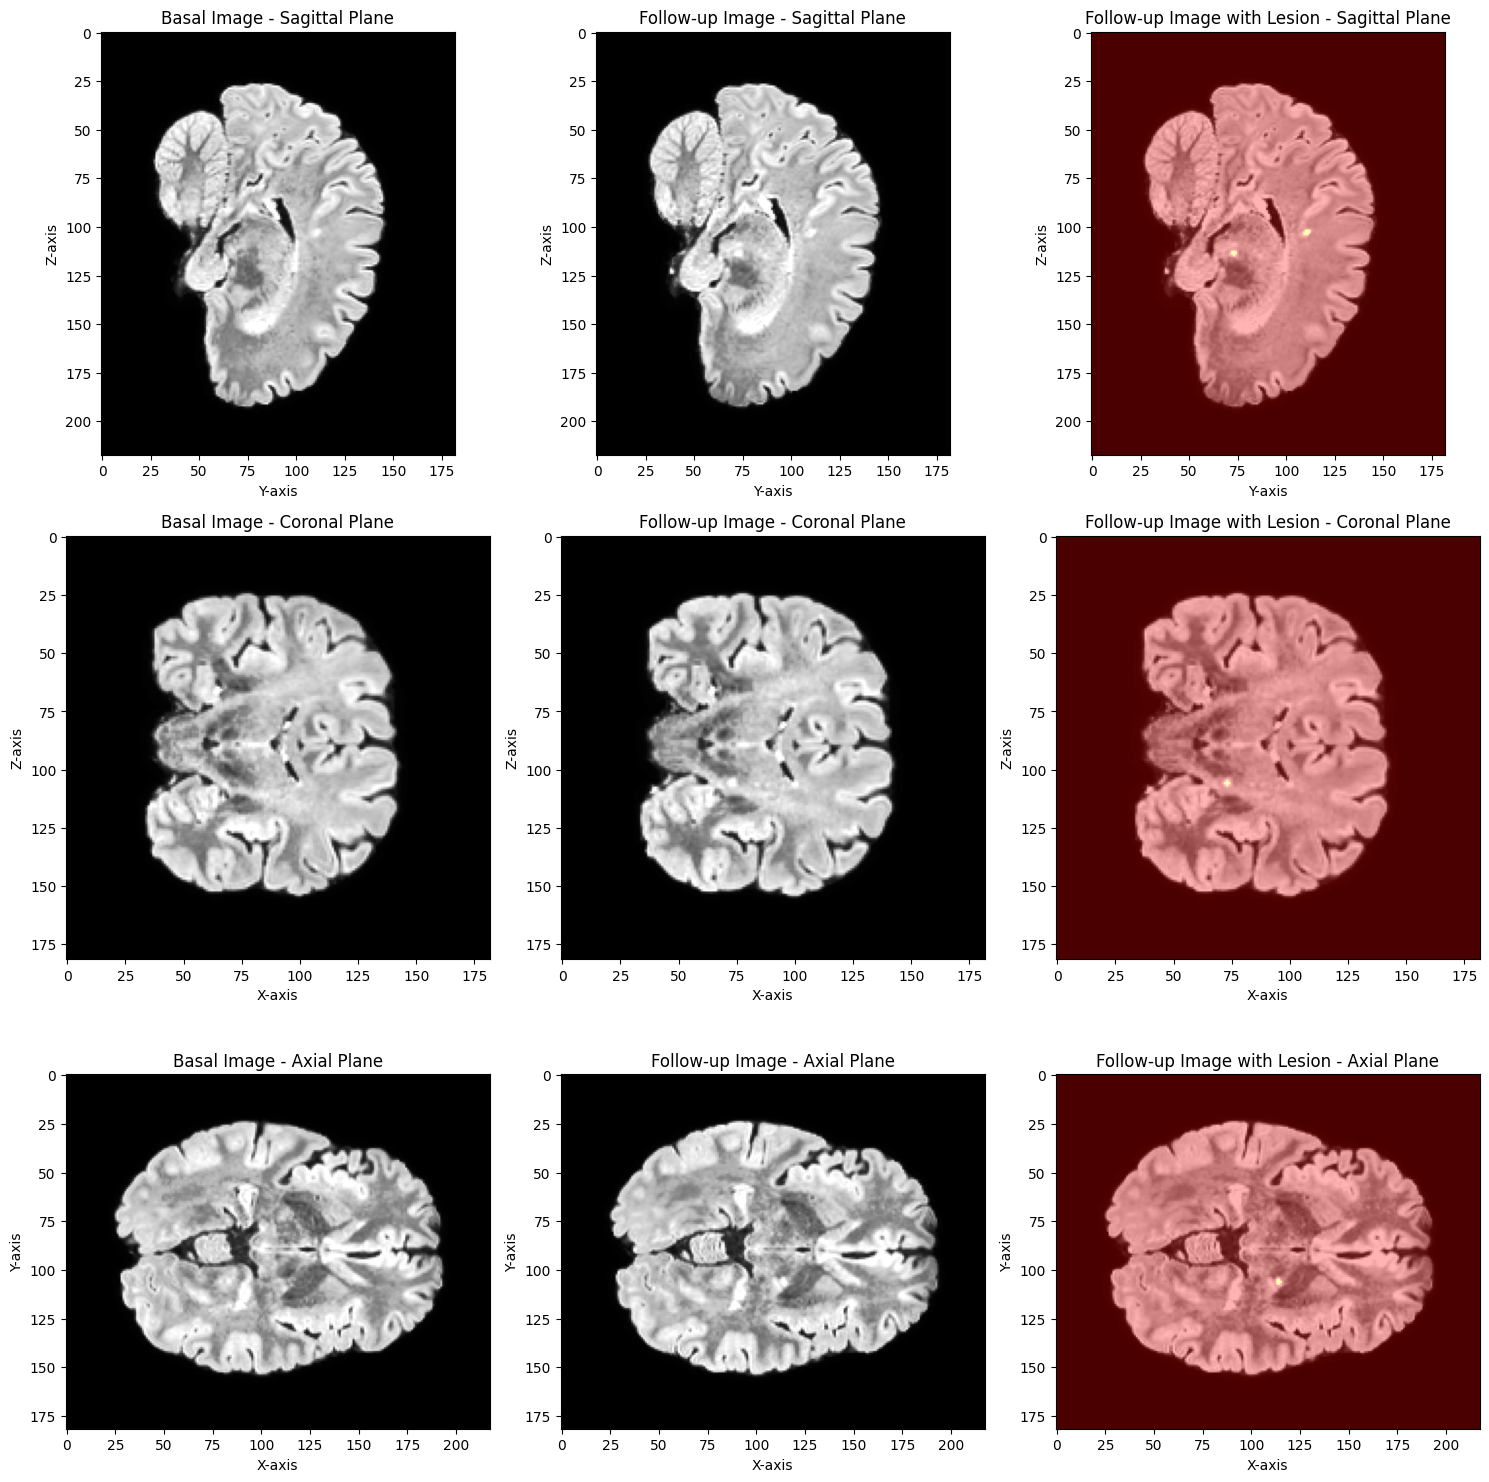

In [ ]:
if new_lesion_prediction_locations:
    plot_follow_up_lesion_planes(basal_image, follow_up_image, predictions, sample_new_lesion_prediction_central_voxel, zoom_size=20, apply_zoom=False)

## Análisis cuantitativo de los resultados

In [33]:
resultados_basal = []
resultados_new = []
for case_id in test_ids:
    label_path, image_path = get_image_path(case_id, DATASET, labels=True, preds=True)
    basal_metrics = compute_metrics(
        reference_file=label_path,
        prediction_file=image_path,
        image_reader_writer=SimpleITKIO(),
        labels_or_regions=[1]
    )['metrics'][1]
    basal_metrics['case_id'] = case_id
    resultados_basal.append(basal_metrics)
    
    new_metrics = compute_metrics(
        reference_file=label_path,
        prediction_file=image_path,
        image_reader_writer=SimpleITKIO(),
        labels_or_regions=[2]
    )['metrics'][2]
    new_metrics['case_id'] = case_id
    resultados_new.append(new_metrics)
    


In [34]:
import pandas as pd

dataframeBasal = pd.DataFrame(resultados_basal)
dataframeNew = pd.DataFrame(resultados_new)

In [35]:
dataframeBasal['label'] = 1
dataframeNew['label'] = 2

In [36]:
dataframe = pd.concat([dataframeBasal, dataframeNew])

In [37]:
dataframe[dataframe['label'] == 1].describe()

,Dice,IoU,FP,TP,FN,TN,n_pred,n_ref,label
count,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,58.000000,58.000000,58.0
mean,0.041017,0.022690,7521.706897,330.793103,2307.137931,7.210872e+06,7852.500000,2637.931034,1.0
std,0.077473,0.045164,8888.985256,779.920953,4352.219536,9.825608e+03,8976.317266,4906.280128,0.0
min,0.000000,0.000000,53.000000,0.000000,0.000000,7.175360e+06,56.000000,0.000000,1.0
25%,0.000000,0.000000,1316.750000,0.000000,28.750000,7.206622e+06,1392.000000,28.750000,1.0
50%,0.000361,0.000180,3965.500000,1.000000,386.000000,7.214220e+06,4664.000000,424.500000,1.0
75%,0.051224,0.026285,10235.250000,141.250000,2582.250000,7.217774e+06,10653.500000,3578.750000,1.0
max,0.369730,0.226791,45236.000000,4236.000000,22090.000000,7.220753e+06,45250.000000,24350.000000,1.0


In [ ]:
dataframe[dataframe['label'] == 2].describe()


,Dice,IoU,FP,TP,FN,TN,n_pred,n_ref,label
count,41.0,41.0,58.000000,58.0,58.0,5.800000e+01,58.000000,58.0,58.0
mean,0.0,0.0,203.965517,0.0,0.0,7.220828e+06,203.965517,0.0,2.0
std,0.0,0.0,393.202415,0.0,0.0,3.932024e+02,393.202415,0.0,0.0
min,0.0,0.0,0.000000,0.0,0.0,7.219406e+06,0.000000,0.0,2.0
25%,0.0,0.0,0.000000,0.0,0.0,7.220877e+06,0.000000,0.0,2.0
50%,0.0,0.0,42.500000,0.0,0.0,7.220990e+06,42.500000,0.0,2.0
75%,0.0,0.0,155.000000,0.0,0.0,7.221032e+06,155.000000,0.0,2.0
max,0.0,0.0,1626.000000,0.0,0.0,7.221032e+06,1626.000000,0.0,2.0
